In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



# Convert milligravities to m/s2
MG_TO_MS2 = 0.00980665

def process_data(data):
    # Rename columns: input data has columns: time, x, y, z
    data = data.rename(columns={'time': 't', 'x': 'ax', 'y': 'ay', 'z': 'az'})
    
    # Convert time to seconds
    data['t'] = data['t'] / 1000.0
    
    data = data.dropna()
    
    # Convert acceleration from mg to m/s²
    for acc in ['ax', 'ay', 'az']:
        data[acc] = data[acc] * MG_TO_MS2

    # Replace outliers with median values.
    for acc in ['ax', 'ay', 'az']:
        median_val = np.median(data[acc])
        if median_val != 0:
            outlier_idx = np.abs(data[acc] / median_val) > 1.5
            data.loc[outlier_idx, acc] = median_val

    # Compute velocity
    data['vx'] = cumulative_trapezoid(data['ax'], data['t'], initial=0)
    data['vy'] = cumulative_trapezoid(data['ay'], data['t'], initial=0)
    data['vz'] = cumulative_trapezoid(data['az'], data['t'], initial=0)

    # Compute position
    data['x_pos'] = cumulative_trapezoid(data['vx'], data['t'], initial=0)
    data['y_pos'] = cumulative_trapezoid(data['vy'], data['t'], initial=0)
    data['z_pos'] = cumulative_trapezoid(data['vz'], data['t'], initial=0)
    
    return data



In [388]:
data = pd.read_csv("data/trial1.csv")
data = process_data(data)
data.head()


,t,ax,ay,az,vx,vy,vz,x_pos,y_pos,z_pos
0,0.003,2.314369,-1.019892,-9.532064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.025,2.549729,-1.019892,-9.845877,0.053505,-0.022438,-0.213157,0.000589,-0.000247,-0.002345
2,0.046,2.510502,-1.019892,-9.571290,0.106638,-0.043855,-0.417038,0.002270,-0.000943,-0.008962
3,0.067,2.432049,-1.019892,-9.688970,0.158534,-0.065273,-0.619270,0.005054,-0.002089,-0.019843
4,0.089,2.432049,-1.019892,-9.767423,0.212039,-0.087711,-0.833291,0.009131,-0.003772,-0.035821


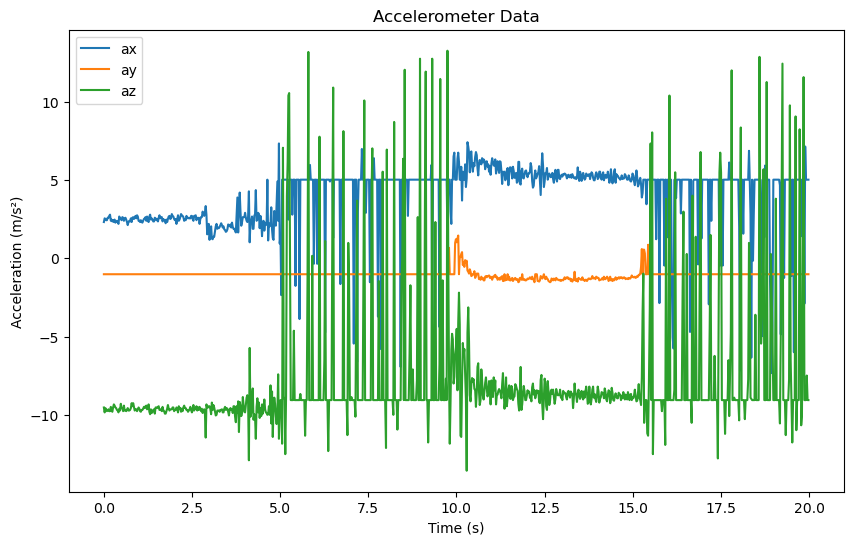

In [389]:
plt.figure(figsize=(10, 6))
for acc in ['ax', 'ay', 'az']:
    plt.plot(data['t'], data[acc], label=acc)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Data")
plt.legend()
plt.show()


In [390]:
# Label the data 
# According to the experiment:
#   - 0 ≤ t < 5 s: Steady (label 0)
#   - 5 ≤ t < 10 s: Shaken (label 1)
#   - 10 ≤ t < 15 s: Steady (label 0)
#   - 15 ≤ t < 20 s: Shaken (label 1)
def label_motion(t):
    if 0 <= t < 5:
        return 0
    elif 5 <= t < 10:
        return 1
    elif 10 <= t < 15:
        return 0
    elif 15 <= t < 20:
        return 1
    else:
        return np.nan

data['label'] = data['t'].apply(label_motion)
data = data.dropna(subset=['label'])
data['label'] = data['label'].astype(int)

data['acc_mag'] = np.sqrt(data['ax']**2 + data['ay']**2 + data['az']**2)
data['vel_mag'] = np.sqrt(data['vx']**2 + data['vy']**2 + data['vz']**2)
data['pos_mag'] = np.sqrt(data['x_pos']**2 + data['y_pos']**2 + data['z_pos']**2)

data.sample(5)

,t,ax,ay,az,vx,vy,vz,x_pos,y_pos,z_pos,label,acc_mag,vel_mag,pos_mag
142,3.109,1.372931,-1.019892,-9.375157,7.686629,-3.167783,-29.959355,12.028716,-4.919567,-46.489886,0,9.529884,31.091511,48.272163
485,10.793,6.237029,-1.412158,-8.472946,38.638887,-10.556211,-86.367441,173.493017,-59.011352,-509.560214,0,10.615344,95.203635,541.510645
505,11.231,6.197803,-1.372931,-8.472946,41.226980,-11.086437,-90.033991,190.985193,-63.749578,-548.185000,0,10.587186,99.642824,583.991564
264,5.801,5.021005,-1.019892,13.180138,15.488388,-5.912429,-53.094439,41.559160,-17.142056,-160.846653,1,14.140958,55.622535,167.010956
602,13.351,5.099458,-0.862985,-8.002226,52.542560,-13.883451,-108.449350,290.465207,-90.205265,-758.503849,0,9.528108,121.304296,817.211793


In [391]:
feature_cols = ['ax', 'ay', 'az', 'acc_mag', 'vel_mag', 'pos_mag']
X = data[feature_cols]
y = data['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])


Number of training samples: 625
Number of testing samples: 269


Classification Accuracy: 71.75%

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.90      0.75       129
           1       0.86      0.55      0.67       140

    accuracy                           0.72       269
   macro avg       0.75      0.72      0.71       269
weighted avg       0.76      0.72      0.71       269

Confusion Matrix:


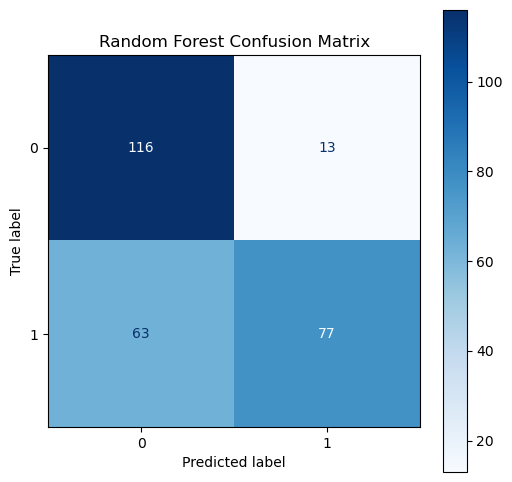

In [392]:

# Logistic regression
lr = LogisticRegression(max_iter=50000, solver='lbfgs')
lr.fit(X_train, y_train)

preds = lr.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("Classification Accuracy: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, preds))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Random Forest Confusion Matrix")
plt.show()

Random Forest Accuracy: 99.63%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       129
           1       1.00      0.99      1.00       140

    accuracy                           1.00       269
   macro avg       1.00      1.00      1.00       269
weighted avg       1.00      1.00      1.00       269

Confusion Matrix:


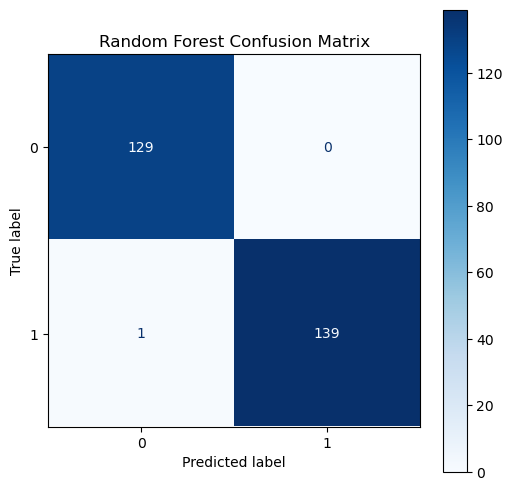

In [393]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test)
print("Random Forest Accuracy: {:.2f}%".format(accuracy_score(y_test, preds_rf) * 100))
print("\nClassification Report:")
print(classification_report(y_test, preds_rf))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, preds_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Random Forest Confusion Matrix")
plt.show()
